<a href="https://colab.research.google.com/github/architagarwal2103/WordForThought/blob/main/Week%203/ArchitAgarwal/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.io import wavfile
import wave
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import librosa.display
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from google.colab import drive
import os
import zipfile
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt


drive.mount('/content/drive')

zip_file_path = "/content/drive/MyDrive/Crema.zip"
extract_path = "/content/CREMA"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

import librosa
import librosa.display
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


Mounted at /content/drive
Dataset extracted to: /content/CREMA


In [ ]:
def extract_mel_spectrogram(directory):
    labels = []
    mel_specs = []

    for file in os.scandir(directory):
        if file.name.endswith(".wav"):
            y, sr = librosa.core.load(file.path)
            label = str(file.name).split('_')[2]
            labels.append(label)

            spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
            spect = librosa.power_to_db(spect, ref=np.max)

            if spect.shape[1] != 108:
              spect.resize(128,108, refcheck=False)

            mel_specs.append(spect)

    X = np.array(mel_specs)

    labels = pd.Series(labels)
    label_dict = {
        "SAD": 0,
        "ANG": 1,
        "DIS": 2,
        "FEA": 3,
        "HAP": 4,
        "NEU": 5
    }
    y = labels.map(label_dict)

    return X, y

X, y = extract_mel_spectrogram('/content/CREMA')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)
X_train /= -80
X_test /= -80
X_train = X_train.reshape(X_train.shape[0], 128, 108, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 108, 1)
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)

In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (7442, 128, 108)
Shape of y: (7442,)


In [ ]:
X_train.min()

-1.0

In [ ]:
print(X_train.shape)

(5953, 128, 108, 1)


In [ ]:
print(y_train.shape)

(5953, 6)


#Using LSTM

In [ ]:
def extract_mfcc(directory):
    labels = []
    mfccs = []

    for file in os.scandir(directory):
        if file.name.endswith(".wav"):
            y, sr = librosa.core.load(file.path, sr=None)
            label = str(file.name).split('_')[2]
            labels.append(label)

            # Extract MFCCs
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=512)
            mfcc = mfcc.T  # Transpose to get time steps as rows

            mfccs.append(mfcc)

    labels = pd.Series(labels)
    label_dict = {
        "SAD": 0,
        "ANG": 1,
        "DIS": 2,
        "FEA": 3,
        "HAP": 4,
        "NEU": 5
    }
    y = labels.map(label_dict)

    return np.array(mfccs, dtype=object), np.array(y)

X, y = extract_mfcc('/content/CREMA')


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 3000 # Maximum number of timesteps
X = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32', value=0.0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(max_len, 13), activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False, activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # 6 output classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 300, 128)            │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 300, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,158 (488.90 KB)

 Trainable params: 124,774 (487.40 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32
)


Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.1797 - loss: 2.0905 - val_accuracy: 0.1706 - val_loss: 1.7936
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1640 - loss: 1.8567 - val_accuracy: 0.1706 - val_loss: 1.7936
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.1662 - loss: 1.8268 - val_accuracy: 0.1706 - val_loss: 1.7952
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.1634 - loss: 1.8125 - val_accuracy: 0.1706 - val_loss: 1.7955
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.1877 - loss: 1.7965 - val_accuracy: 0.1713 - val_loss: 1.7948
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.1567 - loss: 1.7957 - val_accuracy: 0.1713 - val_loss: 1.7933
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1576 - loss: 1.7958 - val_accuracy: 0.1706 - val_loss: 1.7925
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.1691 - loss: 1.7924 - val_acc

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1597 - loss: 1.7924
Test Accuracy: 17.06%


#Transfer Learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

base_model = MobileNetV2(input_shape=(128, 108, 3), include_top=False, weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


<ipython-input-6-eb7a6f183fa1>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(128, 108, 3), include_top=False, weights='imagenet')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.2886 - loss: 1.7567 - val_accuracy: 0.3761 - val_loss: 1.5299
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3627 - loss: 1.5268 - val_accuracy: 0.3862 - val_loss: 1.4863
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3904 - loss: 1.4935 - val_accuracy: 0.3895 - val_loss: 1.4763
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4082 - loss: 1.4527 - val_accuracy: 0.3976 - val_loss: 1.4687
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3939 - loss: 1.4665 - val_accuracy: 0.3969 - val_loss: 1.4641
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4218 - loss: 1.4160 - val_accuracy: 0.3983 - val_loss: 1.4575
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4263 - loss: 1.3968 - val_accuracy: 0.4063 - val_loss: 1.4543
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4186 - loss: 1.3947 - val_ac

#CNN Architecture

In [ ]:
X_train = X_train[:, :, :, 0]  # Take only the first channel
X_test = X_test[:, :, :, 0]    # Take only the first channel

# Reshape to (128, 108, 1)
X_train = X_train.reshape(X_train.shape[0], 128, 108, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 108, 1)

In [ ]:
X_train[0].shape

(128, 108, 1)

In [ ]:
input_shape = (128, 108,1)
inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(8, (3,3), activation='relu')(inputs)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(16, (3,3), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)

x = layers.Dense(120, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(84, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(6, activation = 'softmax')(x)
lenet = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
lenet.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
lenet.summary()
epochs = 20
# y_train=y_train.toarray()
history_lenet = lenet.fit(x=X_train,
                          y=y_train,
                          epochs=epochs,
                          shuffle=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 108, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 106, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 63, 53, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 63, 53, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 51, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 30, 25, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 120)                 │       1,440,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,452,042 (5.54 MB)

 Trainable params: 1,452,042 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.1871 - loss: 1.8294
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2991 - loss: 1.6611
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3631 - loss: 1.5132
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3548 - loss: 1.5504
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3937 - loss: 1.4622
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3934 - loss: 1.4623
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4320 - loss: 1.4220
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4073 - loss: 1.4236
Epoch 9/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4121 - loss: 1.4246
Epoch 10/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4158 - loss: 1.4051
Epoch 11/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4509 - loss: 1.3653
Epoch 12/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

In [ ]:
test_loss, test_accuracy = lenet.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3850 - loss: 1.5649
Test Loss: 1.5227487087249756
Test Accuracy: 40.23


#Exploratory Data Analysis

In [ ]:
# import os

# # Dataset identifier on Kaggle
# dataset_name = "ejlok1/cremad"  # Replace with the correct Kaggle dataset identifier if different

# # Directory to save the dataset
# download_dir = "crema_dataset"

# # Ensure the directory exists
# os.makedirs(download_dir, exist_ok=True)

# # Download and unzip the dataset
# print("Downloading the dataset...")
# os.system(f"kaggle datasets download -d {dataset_name} -p {download_dir} --unzip")

# print("Download complete. Listing files:")
# # List the downloaded files
# files = os.listdir(download_dir)
# print(files)


Loaded file: /content/CREMA/1001_DFA_ANG_XX.wav
Audio data shape: (50177,)
Sampling rate: 22050


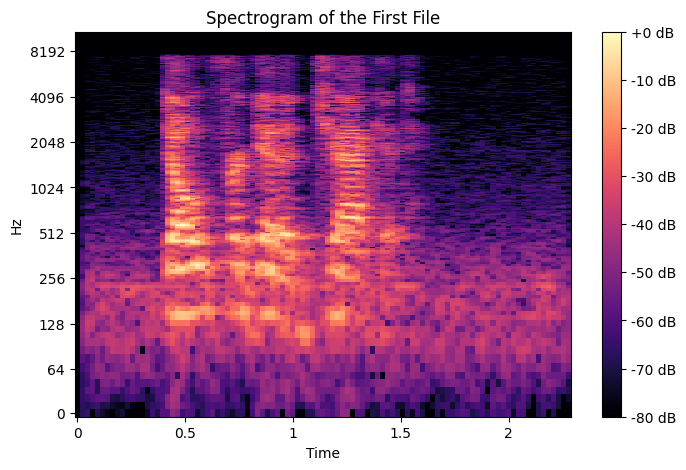

In [ ]:


first_file = "/content/CREMA/1001_DFA_ANG_XX.wav"

y, sr = librosa.load(first_file)

print(f"Loaded file: {first_file}")
print(f"Audio data shape: {y.shape}")
print(f"Sampling rate: {sr}")

spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)

plt.figure(figsize=(8, 5))
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the First File')
plt.show()



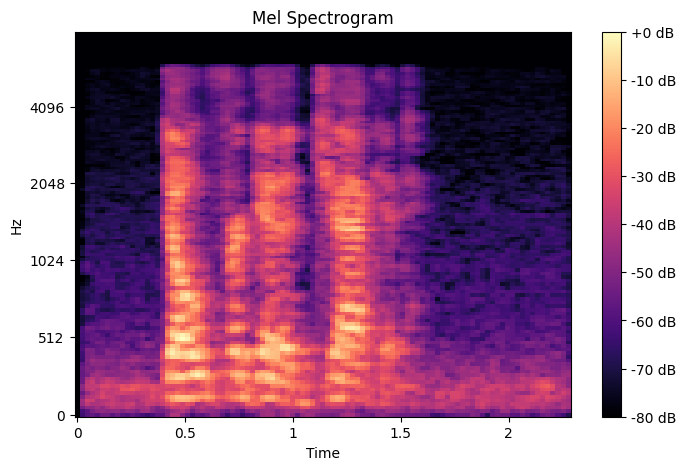

In [ ]:
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
spect = librosa.power_to_db(spect, ref=np.max) # Converting to decibals

plt.figure(figsize=(8,5))
librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

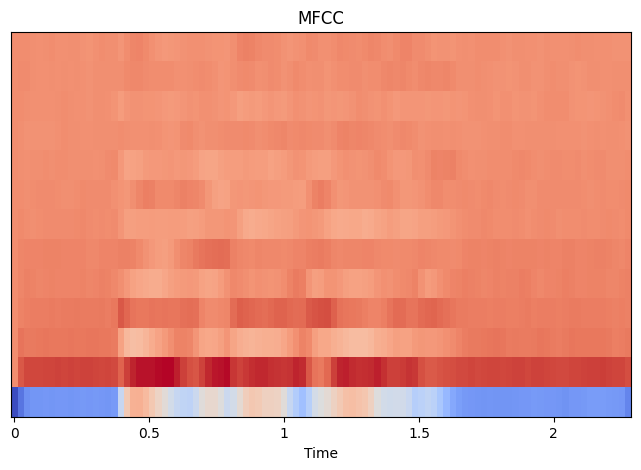

In [ ]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)

plt.figure(figsize=(8,5));
librosa.display.specshow(mfcc, x_axis='time');
plt.title('MFCC');